# Coursera Reviews EDA
- Explore the course metadata and explore relationships between features with rating as the target
- Identify potentially interesting features to pair with sentiment
- Explore word distributions, keywords, etc in reviews.

In [14]:
!pip -q install datasets transformers huggingface_hub

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.stats as stats
import re
import nltk
from nltk.corpus import words
from collections import Counter
import math

In [3]:
nltk.download('words')

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
courses_df = pd.read_csv('/kaggle/input/course-reviews-on-coursera/Coursera_courses.csv')
courses_df.head(3)

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being


In [5]:
reviews_df = pd.read_csv('/kaggle/input/course-reviews-on-coursera/Coursera_reviews.csv')
reviews_df.head(3)

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training


In [6]:
reviews_df.reviews

0          Pretty dry, but I was able to pass with just t...
1          would be a better experience if the video and ...
2          Information was perfect! The program itself wa...
3          A few grammatical mistakes on test made me do ...
4          Excellent course and the training provided was...
                                 ...                        
1454706                                                    g
1454707                                                    .
1454708                                                    .
1454709                                                    .
1454710                                                    G
Name: reviews, Length: 1454711, dtype: object

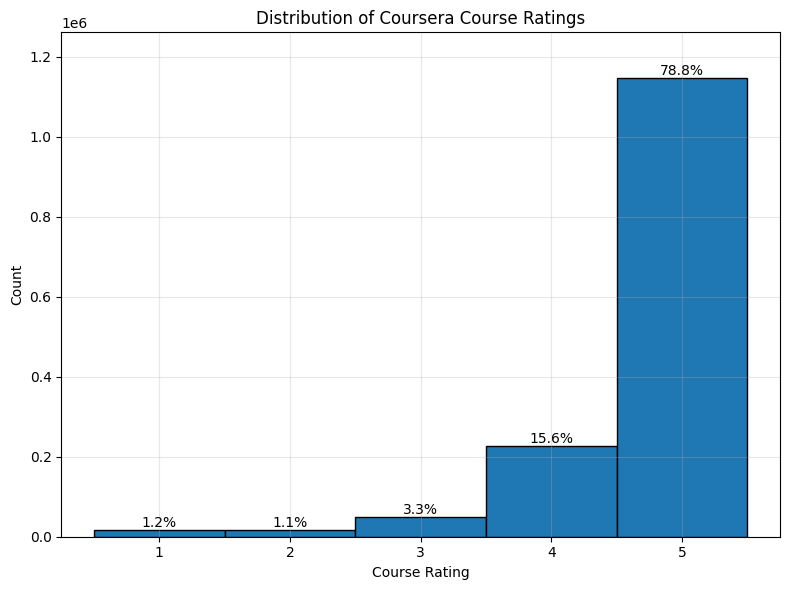

In [5]:
plt.figure(figsize=(8,6))

counts, bins, patches = plt.hist(reviews_df['rating'], 
                                 bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
                                 edgecolor='black')
    
plt.xticks([1, 2, 3, 4, 5])

for count, x in zip(counts, [1, 2, 3, 4, 5]):
    plt.text(x, count, f'{int(count)/len(reviews_df):.1%}', ha='center', va='bottom')
    
plt.xlabel('Course Rating')
plt.ylabel('Count')
plt.title('Distribution of Coursera Course Ratings')
plt.grid(True, alpha=0.3)

# Ensure y-axis starts at 0 and has some padding on top
plt.margins(y=0.1)
plt.tight_layout()
plt.savefig('rating_hist.png')
# Display the plot
plt.show()

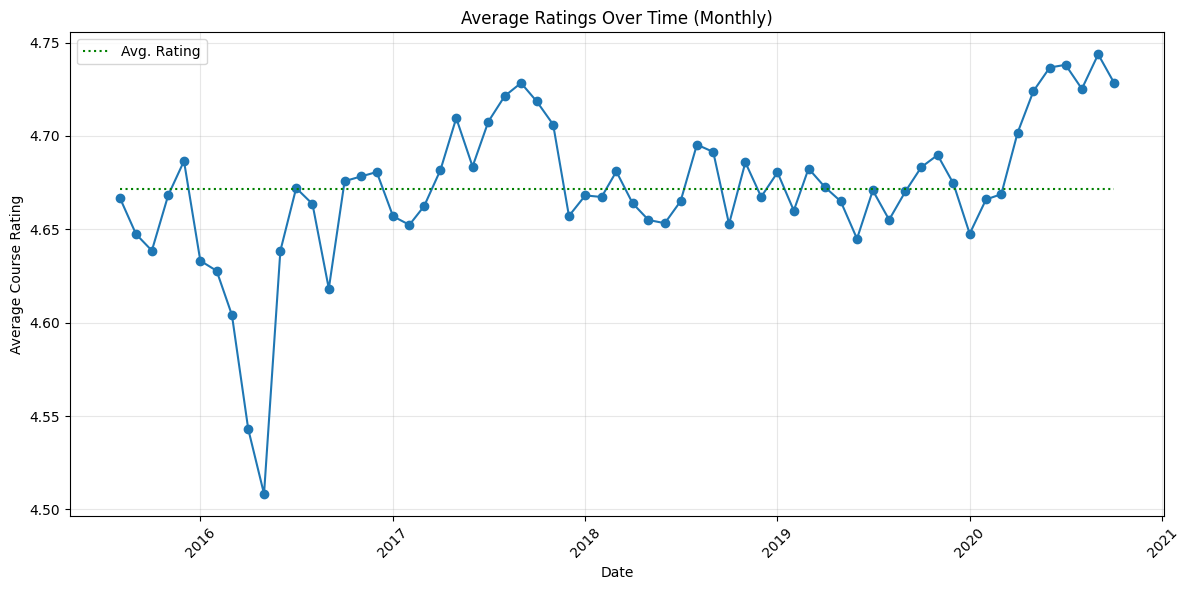

In [6]:
def plot_monthly_avg(df, dates, ratings):
    # Plot average ratings over time
    reviews_df[dates] = pd.to_datetime(reviews_df[dates])
    
    reviews_df['year_month'] = reviews_df[dates].dt.to_period('M')
    monthly_avg = reviews_df.groupby('year_month')[ratings].mean().reset_index()
    monthly_avg['year_month'] = monthly_avg['year_month'].dt.to_timestamp()
    
    # Plot the monthly average
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['year_month'], monthly_avg['rating'], 
             marker='o', linestyle='-', linewidth=1.5)
    
    # Plot overall average
    plt.hlines(y=monthly_avg[ratings].mean(), 
               xmin=monthly_avg['year_month'].min(), 
               xmax=monthly_avg['year_month'].max(), 
               colors='g', linestyles='dotted', label='Avg. Rating')
    
    plt.xlabel('Date')
    plt.ylabel('Average Course Rating')
    plt.title('Average Ratings Over Time (Monthly)')
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.legend()
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.savefig('rating_over_time.png')
    # Show the plot
    plt.show()

plot_monthly_avg(reviews_df, 'date_reviews', 'rating')

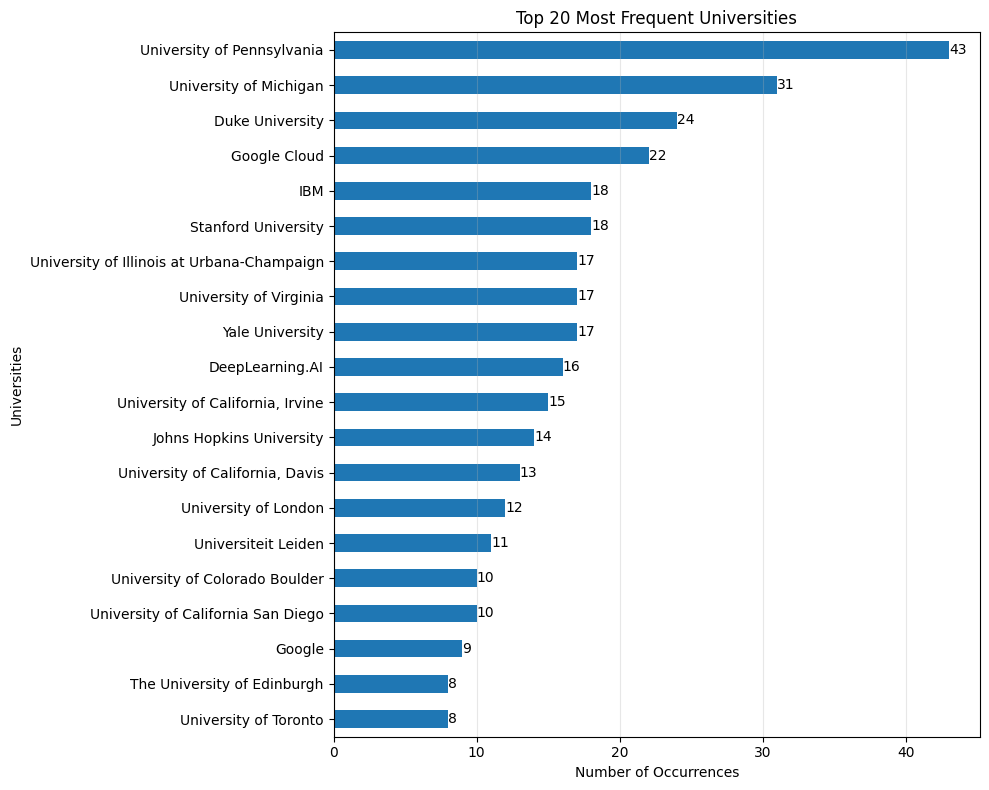

In [7]:
def plot_top_categories(df, column_name, n=20):

    uni_counts = df[column_name].value_counts().head(n)
    
    # Create horizontal bar chart
    plt.figure(figsize=(10, 8))
    uni_counts.plot(kind='barh')
    
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Universities')
    plt.title(f'Top {n} Most Frequent Universities')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Invert y-axis to have highest count at top
    plt.gca().invert_yaxis()
    
    # Add counts on the bars
    for i, v in enumerate(uni_counts):
        plt.text(v, i, str(v), va='center')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('top_universities.png')
    plt.show()

plot_top_categories(courses_df, 'institution')

#### Merge the dataframes

In [7]:
merged_df = pd.merge(courses_df, reviews_df, 
                    on='course_id', 
                    how='inner')  # 'inner' keeps only matching records

In [8]:
# Calculate average ratings per university and counts for each
avg_ratings = merged_df.groupby('institution')['rating'].mean()
rating_counts = merged_df.groupby('institution')['rating'].count()

uni_stats = pd.DataFrame({
    'avg_rating': avg_ratings,
    'n_ratings': rating_counts
})

# Find outliers with IQR
Q1 = uni_stats['avg_rating'].quantile(0.25)
Q3 = uni_stats['avg_rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = uni_stats[(uni_stats['avg_rating'] < lower_bound) | 
                    (uni_stats['avg_rating'] > upper_bound)].reset_index()

def get_hi_low(row, hi, low):
    if row['avg_rating'] > hi:
        return 'High'
    elif row['avg_rating'] < low:
        return 'Low'
    else:
        return "Normal"

outliers['hi_lo'] = outliers.apply(lambda row: get_hi_low(row, upper_bound, lower_bound), axis=1)

print("Potential Outliers (using IQR method):")
if not outliers.empty:
    #print(outliers)
    # Construct Markdown table manually
    md_table = f"| {'Institution'} | Average Rating | Number of Ratings |\n"
    md_table += "|------------|----------------|-------------------|\n"
    for _, row in outliers.iterrows():
        md_table += f"| {row['institution']} | {row['avg_rating']:.2f} | {row['n_ratings']} | {row['hi_lo']} |\n"
    md_table += f"| **Overall Avg** | **{uni_stats['avg_rating'].mean():.2f}** | **{len(merged_df)}** | N/A |\n"
    print(md_table)
else:
    print("No outliers detected.")

Potential Outliers (using IQR method):
| Institution | Average Rating | Number of Ratings |
|------------|----------------|-------------------|
| Advancing Women in Product | 4.33 | 9 | Low |
| ESCP Business School | 4.31 | 153 | Low |
| IE Business School | 4.01 | 82 | Low |
| LearnQuest | 4.32 | 246 | Low |
| New York Institute of Finance | 3.40 | 368 | Low |
| Novosibirsk State University  | 4.03 | 195 | Low |
| Saint Petersburg State University | 3.33 | 204 | Low |
| University of New Mexico | 1.00 | 6 | Low |
| Yandex | 3.42 | 290 | Low |
| **Overall Avg** | **4.65** | **1454711** | N/A |



Potential Average Rating Outliers (using IQR method):
| Institution | Average Rating | Number of Ratings | High/Low |
|------------|----------------|-------------------| ------- |
| Advancing Women in Product | 4.33 | 9 | Low |
| ESCP Business School | 4.31 | 153 | Low |
| IE Business School | 4.01 | 82 | Low |
| LearnQuest | 4.32 | 246 | Low |
| New York Institute of Finance | 3.40 | 368 | Low |
| Novosibirsk State University  | 4.03 | 195 | Low |
| Saint Petersburg State University | 3.33 | 204 | Low |
| University of New Mexico | 1.00 | 6 | Low |
| Yandex | 3.42 | 290 | Low |
| **Overall Avg** | **4.65** | **1454711** | N/A |

#### Cleaning the Reviews - Word Counts + Entropy

In [9]:
# Find entries with no review
print(f"There are {sum(merged_df.reviews.isna())} entries with no review text")

There are 153 entries with no review text


In [8]:
df = merged_df.dropna(subset=['reviews'])
print(f"Dropped {len(merged_df) - len(df)} entries with no reviews")

Dropped 153 entries with no reviews


In [11]:
#df = df[df['reviews'].str.len() < 10]

print(f"There are {len(df[df['reviews'].str.len() < 5])} entries with < 5 characters")
print(f"There are {len(df[df['reviews'].str.len() < 10])} entries with < 10 characters")

There are 29031 entries with < 5 characters
There are 78044 entries with < 10 characters


We notice that a lot of the remaining non null entries have very short reviews. Let's look at some of the entries where there are less than 4 characters. I picked 4 since the word "good" comes up quite frequently.

In [12]:
df[df['reviews'].str.len() < 4].head(10).reviews

7347    das
7372    das
7397    das
7398     no
7399     E>
7400     OK
7401      T
7402      g
7403      .
7404      G
Name: reviews, dtype: object

If we limit it to 10 characters, we see reviews like "its good" or "good" so this seems like a reasonable limit. There may still be entries with nonsensical words.

In [13]:
df[df['reviews'].str.len() < 10].head(8).reviews

318         jhkd
331         jhkd
344         jhkd
916    very good
917     Good..!!
918     its good
941    very good
942     Good..!!
Name: reviews, dtype: object


Review Word Count Stats:
|       |     word_count |
|:------|---------------:|
| count |    1.45456e+06 |
| mean  |   22.3954      |
| std   |   27.5751      |
| min   |    0           |
| 25%   |    6           |
| 50%   |   14           |
| 75%   |   29           |
| max   | 1359           |


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


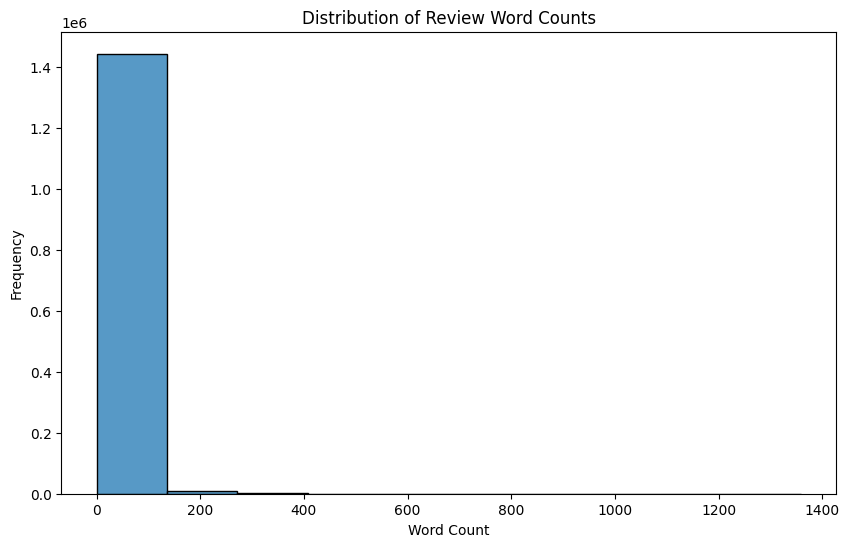

In [21]:
# Review length (word count)
word_count_df = df.copy()
word_count_df['word_count'] = word_count_df['reviews'].apply(lambda x: len(str(x).split()))
print("\nReview Word Count Stats:")
print(df['word_count'].describe().to_markdown())

plt.figure(figsize=(10, 6))
sns.histplot(word_count_df['word_count'], bins=10)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

This plot is not very meaningful, need to cut the outliers to get better idea


97.5th Percentile Cutoff: 91 words


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


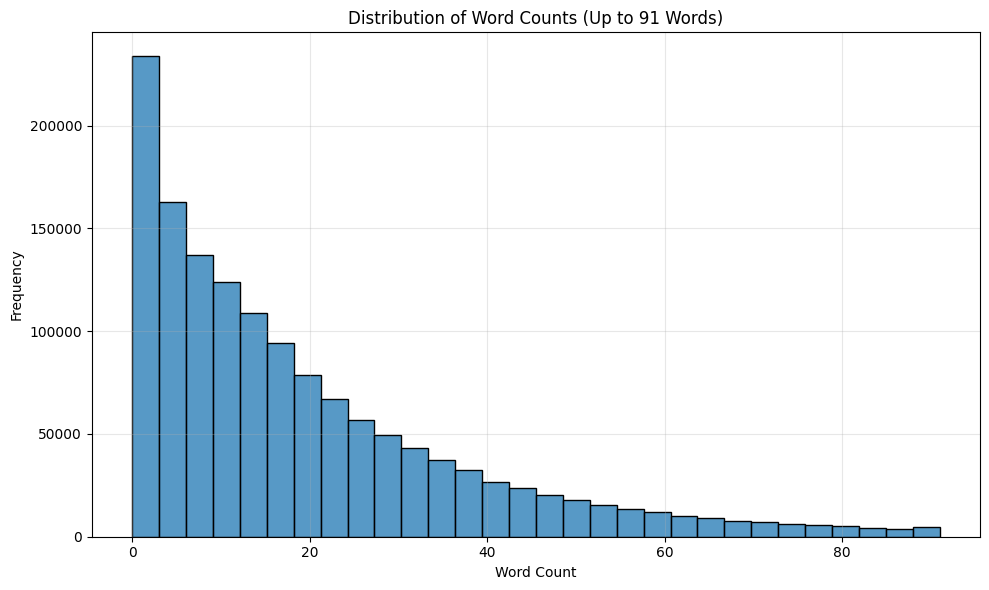


Sample of Outlier Reviews:
| Review Text | Word Count |
|-------------|------------|
| This is an extremely basic course. Machine lear... | 152 |
| I just started week 3 , I have to admit that It... | 93 |
| This course is absolute garbage.  You get no fe... | 107 |
| Have to give a star so I will give it one.  Oth... | 131 |
| I would rename this course as Programming Octav... | 125 |



In [25]:
def plot_word_count_distribution(original_df, review_col='reviews', percentile_cutoff=95, sample_size=5):

    df = original_df.copy()
    df['word_count'] = df[review_col].apply(lambda x: len(str(x).split()))

    # Set word count cutoff to a given percentile. Defult to 95
    cutoff = np.percentile(df['word_count'], percentile_cutoff)
    print(f"\n{percentile_cutoff}th Percentile Cutoff: {cutoff:.0f} words")

    main_range = df['word_count'][df['word_count'] <= cutoff]
    outliers = df[df['word_count'] > cutoff]
    
    # Plot histogram for main range
    plt.figure(figsize=(10, 6))
    sns.histplot(main_range, bins=30)
    plt.title(f'Distribution of Word Counts (Up to {cutoff:.0f} Words)')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('word_count_hist.png')
    plt.show()

    # Make output df of outliers and print to markdown
    if not outliers.empty:
        
        outlier_sample = outliers[[review_col, 'word_count']].head(sample_size)
        
        md_table = "| Review Text | Word Count |\n"
        md_table += "|-------------|------------|\n"
        for _, row in outlier_sample.iterrows():
            # Truncate long text for display (optional)
            text = row[review_col] if len(row[review_col]) < 50 else row[review_col][:47] + "..."
            md_table += f"| {text} | {row['word_count']} |\n"
        
        print("\nSample of Outlier Reviews:")
        print(md_table)


plot_word_count_distribution(df, percentile_cutoff=97.5)

Sample of Outlier Reviews:
| Review Text | Word Count |
|-------------|------------|
| This is an extremely basic course. Machine lear... | 152 |
| I just started week 3 , I have to admit that It... | 93 |
| This course is absolute garbage.  You get no fe... | 107 |
| Have to give a star so I will give it one.  Oth... | 131 |
| I would rename this course as Programming Octav... | 125 |

Next, we'll attempt to define a meaningful review as one with low entropy. Higher entropy suggests a more random distribution of characters, which is more likely to be gibberish over structured language.

In [36]:
def calculate_entropy(text):
    """Calculate Shannon entropy of the text to detect randomness."""
    if not text:
        return 0
    length = len(text)
    char_counts = Counter(text)
    entropy = -sum((count/length) * math.log2(count/length) for count in char_counts.values())
    return entropy

def is_meaningful_review(text, min_alpha_ratio=0.5, max_entropy=4.0, min_dict_ratio=0.3):

    # Get rid of empty reviews
    if not text or pd.isna(text):
        return False
    
    text = str(text).lower()
    
    # Make sure alphabetic characters are at least alpha_ratio of the characters param
    alpha_chars = sum(c.isalpha() for c in text)
    total_chars = len(text.replace(" ", ""))  # coutn chars exclude spaces
    if total_chars == 0:
        return 0
    alpha_ratio = alpha_chars / total_chars
    if alpha_ratio < min_alpha_ratio:
        return 0
    
    # Make sure entropy is smaller than max_entropy param
    entropy = calculate_entropy(text)
    if entropy > max_entropy:  # High entropy indicates randomness
        return 0
    
    # Make sure there is at least one real word in each entry (this will take a long time)
    #word_list = set(words.words())  # NLTK's English word list
    #tokens = re.findall(r'\b[a-z]+\b', text)  # return list of real words in review entry
    #if not tokens:  # No words found
    #    return 0
    
    #dict_words = sum(1 for token in tokens if token in word_list)
    #dict_ratio = dict_words / len(tokens)
    #if dict_ratio < min_dict_ratio:
    #    return 0
    
    return 1

def flag_meaningless_reviews(test_df, review_col='reviews'):
    """Apply the meaningfulness check to a dataframe column and add a flag."""
    df = test_df.copy()
    df['is_meaningful'] = df[review_col].apply(is_meaningful_review)
    return df

# DF with column for meaningless/meaningful tag
result_df = flag_meaningless_reviews(df)

# DF filtered for only tag 1
meaningful_df = result_df[result_df['is_meaningful'] == 1].copy()

# Summary of meaningful vs. meaningless
print("\nSummary:")
print(result_df['is_meaningful'].value_counts())
print


Summary:
is_meaningful
0    782993
1    671565
Name: count, dtype: int64


#### Reviews per Course
- Are there courses with very few or a ton of course reviews?

In [9]:
# Number of reviews per course
reviews_per_course = df.groupby('course_id').size()
print("Reviews per Course Stats:")
print(f'| Stat | Value |')
print(reviews_per_course.describe().to_markdown())
print(f'| median | {reviews_per_course.median()} |')

Reviews per Course Stats:
| Stat | Value |
|       |        0 |
|:------|---------:|
| count |   604    |
| mean  |  2408.21 |
| std   |  4599.04 |
| min   |     3    |
| 25%   |   374.25 |
| 50%   |  1071.5  |
| 75%   |  2408.25 |
| max   | 45218    |
| median | 1071.5 |


Reviews per Course Stats:
| Stat | Value |
|:------|---------:|
| count |   604    |
| mean  |  2408.21 |
| std   |  4599.04 |
| min   |     3    |
| 25%   |   374.25 |
| 50%   |  1071.5  |
| 75%   |  2408.25 |
| max   | 45218    |
| median | 1071.5 |

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


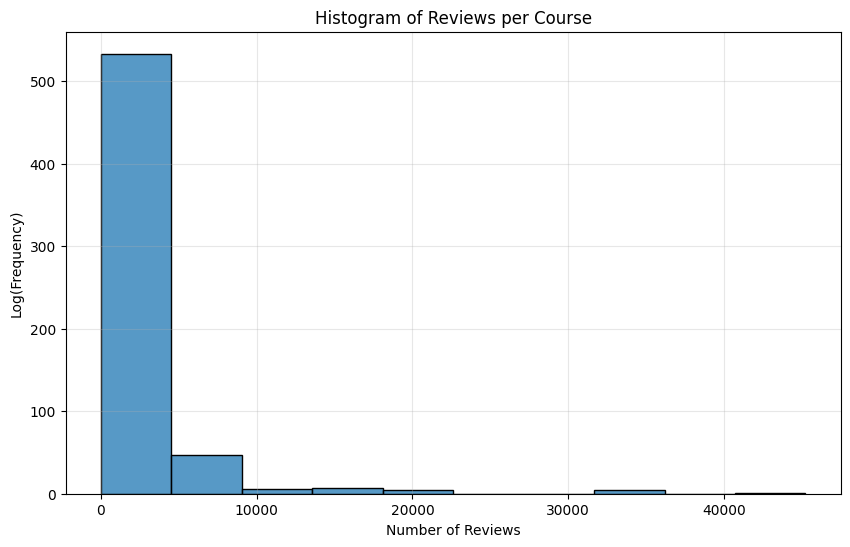

In [16]:
# Rebin the course review data to 1-10, 10-100, 100+
plt.figure(figsize=(10, 6))
sns.histplot(reviews_per_course, bins=10)
plt.title('Histogram of Reviews per Course')
plt.xlabel('Number of Reviews')
plt.ylabel('Log(Frequency)')
plt.grid(True, alpha=0.3)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

Not super meaningful. Let's do the same thing with review count as we did with character count


97.5th Percentile Cutoff: 14295 reviews


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


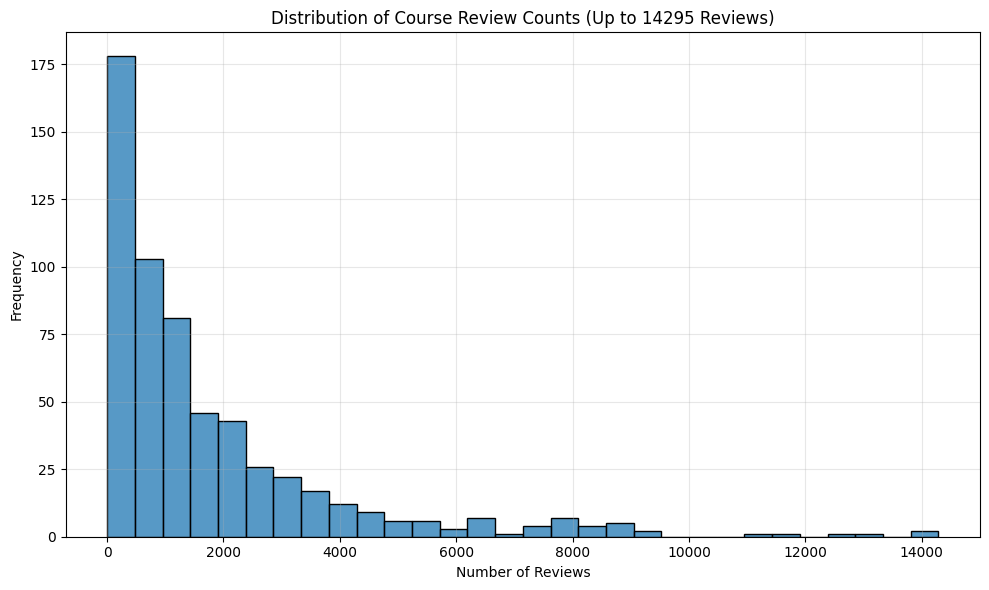


Sample of Outlier Reviews:
| Course ID | Review Count |
|-------------|------------|
| ai-for-everyone | 21624 |
| data-scientists-tools | 17595 |
| deep-neural-network | 17850 |
| excel-essentials | 21248 |
| gcp-fundamentals | 17419 |



In [34]:
def plot_review_count_distribution(original_df, id_col='course_id', percentile_cutoff=95, sample_size=5):

    copy_df = original_df.copy()
    df = copy_df.groupby(id_col).size().reset_index(name='review_count')
    
    # Set review count cutoff to a given percentile for plotting. Defult to 95
    cutoff = np.percentile(df['review_count'], percentile_cutoff)
    print(f"\n{percentile_cutoff}th Percentile Cutoff: {cutoff:.0f} reviews")

    main_range = df['review_count'][df['review_count'] <= cutoff]
    outliers = df[df['review_count'] > cutoff]
    
    # Plot histogram for main range
    plt.figure(figsize=(10, 6))
    sns.histplot(main_range, bins=30)
    plt.title(f'Distribution of Course Review Counts (Up to {cutoff:.0f} Reviews)')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('review_count_hist.png')
    plt.show()

    # Make output df of outliers and print to markdown
    if not outliers.empty:
        
        outlier_sample = outliers[[id_col, 'review_count']].head(sample_size)
        
        md_table = "| Course ID | Review Count |\n"
        md_table += "|-------------|------------|\n"
        for _, row in outlier_sample.iterrows():
            # Truncate long text for display (optional)
            text = row[id_col]
            md_table += f"| {text} | {row['review_count']} |\n"
        
        print("\nSample of Outlier Reviews:")
        print(md_table)


plot_review_count_distribution(df, percentile_cutoff=97.5)

Sample of Outlier Reviews:
| Course ID | Review Count |
|-------------|------------|
| ai-for-everyone | 21624 |
| data-scientists-tools | 17595 |
| deep-neural-network | 17850 |
| excel-essentials | 21248 |
| gcp-fundamentals | 17419 |

#### Finding *Meaningful* Reviews
- We'll use word/chracter counts and distributions to calculate entropy to attempt to tag meaningless entries

## Sentiment Analysis - DistilBERT Fine Tuning

In [12]:
torch.cuda.is_available()

False

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")